In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('bmh')
%matplotlib inline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
pd.options.display.max_rows = 14
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import sklearn.model_selection as ms
from sklearn.preprocessing import Imputer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

In [68]:
boston = pd.read_csv('bostonhousing.csv')
boston.head()

ID     crim    zn  indus  chas    nox     rm   age     dis  rad  tax  \
0   1  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296   
1   2  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242   
2   3  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242   
3   4  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222   
4   5  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222   

   ptratio   black  lstat  medv  
0     15.3  396.90   4.98  24.0  
1     17.8  396.90   9.14  21.6  
2     17.8  392.83   4.03  34.7  
3     18.7  394.63   2.94  33.4  
4     18.7  396.90   5.33  36.2

In [69]:
def splitting(a,b,target):
    split = ms.StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for training_indices, test_indices in split.split(a, b):
        stratified_train_set = a.loc[training_indices]
        stratified_test_set = a.loc[test_indices]
        fea_train, lab_train = (stratified_train_set.drop(target, axis = 1), stratified_train_set[target[0]].copy())
        fea_test, lab_test = (stratified_test_set.drop(target, axis = 1), stratified_test_set[target[0]].copy())
    return stratified_train_set, stratified_test_set, fea_train, lab_train, fea_test, lab_test
def catnum(features, col):
    num, cat = (fea_train.drop(col, axis = 1), fea_train[col])
    return num, cat
def meanerror(a,b):
    print('(meansquareerror, r2score) = ' , (np.sqrt(mean_squared_error(a,b)), r2_score(a,b)))
def crossval(reg, data_tr, labels):
    scores = cross_val_score(reg, data_tr, labels, scoring='neg_mean_squared_error', cv=10)
    sq_scores = np.sqrt(-scores)
    print('(cross_val_mean, cross_val_std) = ' , (sq_scores.mean(), sq_scores.std()))

In [70]:
lstat1 = boston['lstat'] // 5.5

In [71]:
lstat1.unique()

array([ 0.,  1.,  2.,  3.,  5.,  4.,  6.])

In [72]:
boston.groupby(lstat1).size()

lstat
0.0     78
1.0    168
2.0    127
3.0     77
4.0     33
5.0     17
6.0      6
dtype: int64

In [73]:
lstat1[lstat1 >= 4] = 4

In [74]:
boston.groupby(lstat1).size()

lstat
0.0     78
1.0    168
2.0    127
3.0     77
4.0     56
dtype: int64

In [75]:
stratified_train_set, stratified_test_set, fea_train, lab_train, fea_test, lab_test = splitting(boston, lstat1, ['medv'])

In [76]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column_names):
        self.column_names = column_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.column_names].values

In [77]:
%run 'CategoricalEncoder.py'

In [78]:
num_col, cat_col = catnum(fea_train, ['chas'])
numeric_cols = list(num_col)
categorical_cols = ['chas']

In [79]:
numeric_cols_pipeline = Pipeline([('selector', ColumnSelector(list(num_col))),
                                    ('standard_scaler', StandardScaler())
                                 ])

In [80]:
categorical_cols_pipeline = Pipeline([('selector', ColumnSelector(categorical_cols)),
                                      ('encoder', CategoricalEncoder(encoding='onehot-dense'))
                                     ])
full_pipeline = FeatureUnion(transformer_list=[('numeric_pipeline', numeric_cols_pipeline),
                                               ('categorical_pipeline', categorical_cols_pipeline)])

In [81]:
boston_transformed = full_pipeline.fit_transform(stratified_train_set)
boston_transformed.shape
boston_transformed

(404, 15)

array([[ 0.65714344, -0.41442674,  1.22033405, ..., -0.93904963,
         1.        ,  0.        ],
       [ 1.61640458, -0.40447334, -0.50274138, ...,  0.73635294,
         1.        ,  0.        ],
       [-0.44114106, -0.41167568,  1.43571848, ..., -1.37038257,
         1.        ,  0.        ],
       ..., 
       [ 1.53299057,  0.12494139, -0.50274138, ...,  0.82234214,
         1.        ,  0.        ],
       [-1.31003703, -0.41490002,  0.03571969, ..., -0.64502202,
         1.        ,  0.        ],
       [-0.51065274, -0.41118333, -0.50274138, ..., -1.09993265,
         1.        ,  0.        ]])

In [82]:
actual = list(lab_train)

In [83]:
import seaborn as sns

In [84]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
x = lin_reg.fit(boston_transformed, lab_train)
h1 = lin_reg.predict(boston_transformed)
h = list(lab_train)
meanerror(h, h1)
crossval(lin_reg, boston_transformed, lab_train)

(meansquareerror, r2score) =  (4.891788570701598, 0.71622265225990667)
(cross_val_mean, cross_val_std) =  (5.0020720984243559, 1.0278452634081963)


# Ridge Regression

In [19]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky", random_state=42)
r1 = ridge_reg.fit(boston_transformed, lab_train)
r2 = ridge_reg.predict(boston_transformed)
meanerror(actual,r2)
crossval(ridge_reg, boston_transformed, lab_train)

(meansquareerror, r2score) =  (4.891941853570807, 0.71620486780869752)
(cross_val_mean, cross_val_std) =  (4.9969635601382549, 1.0374808865531111)


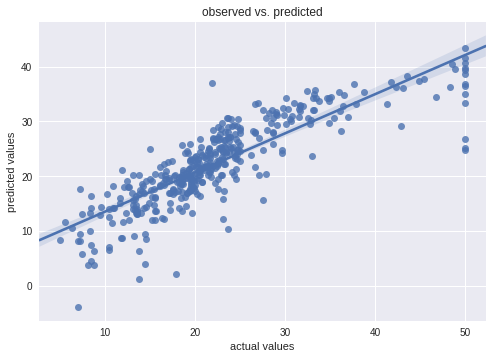

In [20]:
actual1= np.asarray(actual)
plt.figure()
df = pd.DataFrame({'observed' : actual1, 'predicted' : r2})
x = sns.regplot(actual1, r2, df)
plt.xlabel("actual values")
plt.ylabel("predicted values")
plt.title("observed vs. predicted")
plt.show()

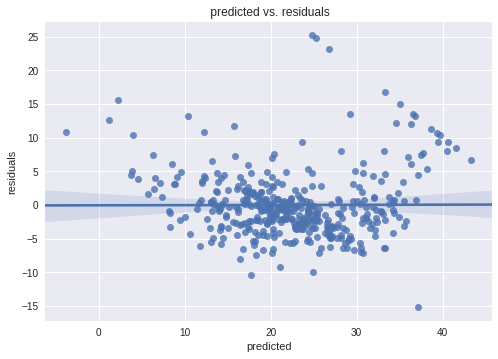

In [21]:
residual = actual - r2
plt.figure()
df = pd.DataFrame({ 'predicted' : r2, 'residuals' : residual})
x = sns.regplot( r2, residual,  df)
plt.xlabel("predicted")
plt.ylabel("residuals")
plt.title(" predicted vs. residuals")
plt.show()

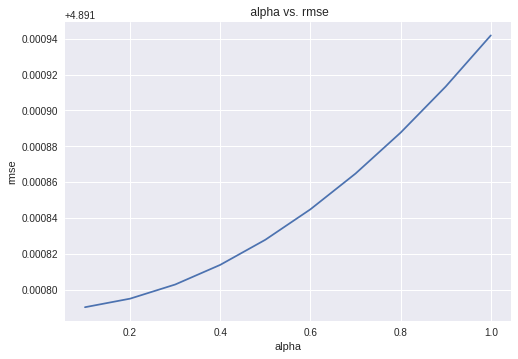

In [22]:
rmse = []
for i in (0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0):
    ridge_reg2 = Ridge(alpha=i, solver="cholesky", random_state=42)
    r3 = ridge_reg2.fit(boston_transformed, lab_train)
    r4 = ridge_reg2.predict(boston_transformed)
    r = np.sqrt(mean_squared_error(actual, r4))
    rmse.append(r)
plt.plot((0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0), rmse)
plt.xlabel("alpha")
plt.ylabel("rmse")
plt.title(" alpha vs. rmse")

#####  In Ridge Regression, with increase in the value of alpha, RMSE also increases

# Lasso Regression

In [23]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
l1 = lasso_reg.fit(boston_transformed, lab_train)
l2 = lasso_reg.predict(boston_transformed)
meanerror(actual,l2)
crossval(lasso_reg, boston_transformed, lab_train)

(meansquareerror, r2score) =  (4.9499057752215707, 0.70943972814146661)
(cross_val_mean, cross_val_std) =  (5.0234435372819188, 1.1529116159552117)


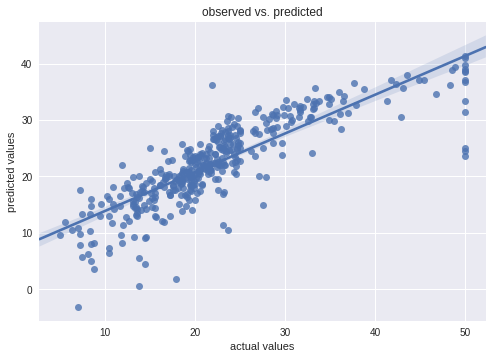

In [24]:
plt.figure()
df = pd.DataFrame({'observed' : actual1, 'predicted' : l2})
x = sns.regplot(actual1, l2, df)
plt.xlabel("actual values")
plt.ylabel("predicted values")
plt.title("observed vs. predicted")
plt.show()

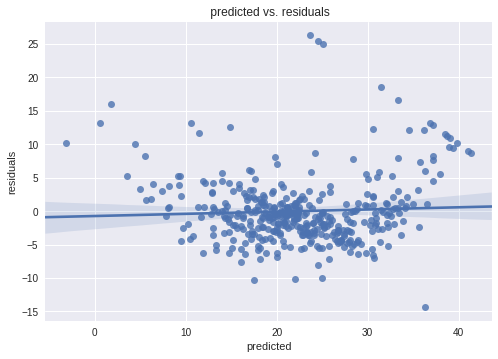

In [25]:
residual = actual - l2
plt.figure()
df = pd.DataFrame({ 'predicted' : l2, 'residuals' : residual})
x = sns.regplot( l2, residual,  df)
plt.xlabel("predicted")
plt.ylabel("residuals")
plt.title(" predicted vs. residuals")
plt.show()

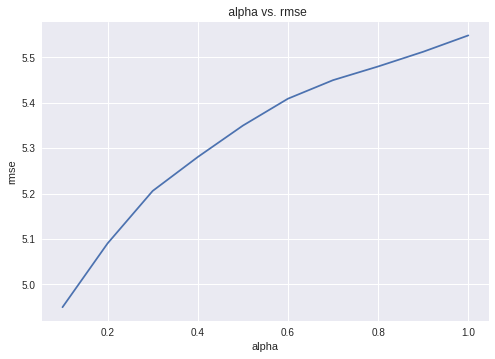

In [26]:
rmse = []
for i in (0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0):
    lasso_reg1 = Lasso(alpha=i)
    l3 = lasso_reg1.fit(boston_transformed, lab_train)
    l4 = lasso_reg1.predict(boston_transformed)
    r = np.sqrt(mean_squared_error(actual, l4))
    rmse.append(r)
plt.plot((0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0), rmse)
plt.xlabel("alpha")
plt.ylabel("rmse")
plt.title(" alpha vs. rmse")

#####  In Lasso Regression also, with increase in the value of alpha, RMSE also increases

# Elastic Net

In [27]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
e1 = elastic_net.fit(boston_transformed, lab_train)
e2 = elastic_net.predict(boston_transformed)
meanerror(actual,e2)
crossval(elastic_net, boston_transformed, lab_train)

(meansquareerror, r2score) =  (4.9604056002216312, 0.70820573788639818)
(cross_val_mean, cross_val_std) =  (4.9950880489789489, 1.206595166717616)


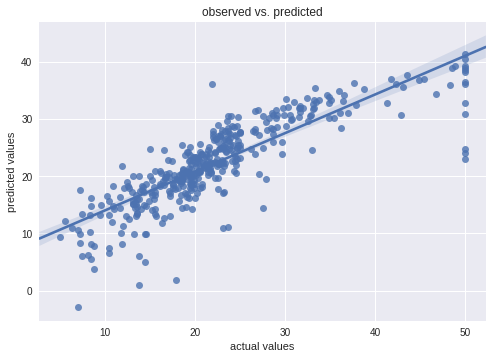

In [28]:
plt.figure()
df = pd.DataFrame({'observed' : actual1, 'predicted' : e2})
x = sns.regplot(actual1, e2, df)
plt.xlabel("actual values")
plt.ylabel("predicted values")
plt.title("observed vs. predicted")
plt.show()

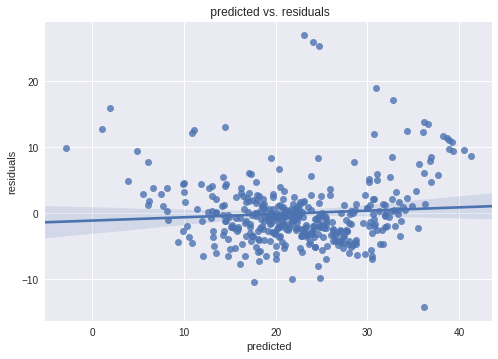

In [29]:
residual = actual - e2
plt.figure()
df = pd.DataFrame({ 'predicted' : e2, 'residuals' : residual})
x = sns.regplot( e2, residual,  df)
plt.xlabel("predicted")
plt.ylabel("residuals")
plt.title(" predicted vs. residuals")
plt.show()

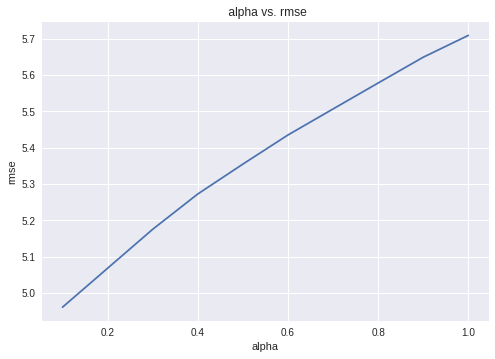

In [30]:
rmse = []
for i in (0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0):
    elastic_net = ElasticNet(alpha=i, l1_ratio=0.5, random_state=42)
    e3 = elastic_net.fit(boston_transformed, lab_train)
    e4 = elastic_net.predict(boston_transformed)
    r = np.sqrt(mean_squared_error(actual, e4))
    rmse.append(r)
plt.plot((0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0), rmse)
plt.xlabel("alpha")
plt.ylabel("rmse")
plt.title(" alpha vs. rmse")

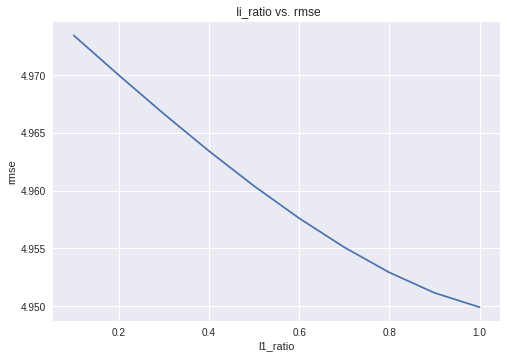

In [31]:
rmse = []
for i in (0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0):
    elastic_net = ElasticNet(alpha=0.1, l1_ratio=i, random_state=42)
    e3 = elastic_net.fit(boston_transformed, lab_train)
    e4 = elastic_net.predict(boston_transformed)
    r = np.sqrt(mean_squared_error(actual, e4))
    rmse.append(r)
plt.plot((0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0), rmse)
plt.xlabel("l1_ratio")
plt.ylabel("rmse")
plt.title(" li_ratio vs. rmse")

# Gradient Boosting

In [32]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
g1 = gbrt.fit(boston_transformed, lab_train)
g2 = gbrt.predict(boston_transformed)
meanerror(actual,g2)
crossval(gbrt, boston_transformed, lab_train)

(meansquareerror, r2score) =  (3.8018013317376393, 0.82859589991446359)
(cross_val_mean, cross_val_std) =  (5.2060276451401011, 1.3119118738982296)


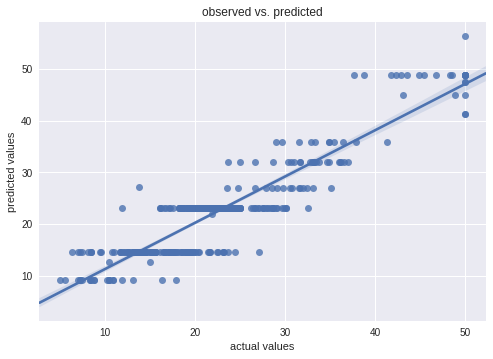

In [33]:
plt.figure()
df = pd.DataFrame({'observed' : actual1, 'predicted' : g2})
x = sns.regplot(actual1, g2, df)
plt.xlabel("actual values")
plt.ylabel("predicted values")
plt.title("observed vs. predicted")
plt.show()

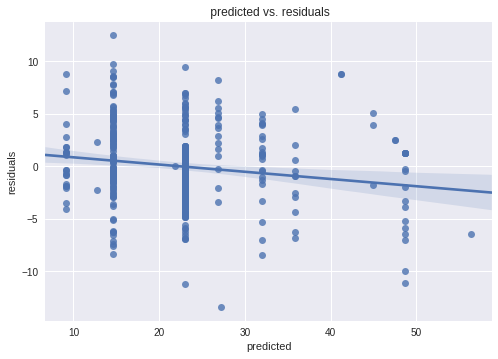

In [34]:
residual = actual - g2
plt.figure()
df = pd.DataFrame({ 'predicted' : g2, 'residuals' : residual})
x = sns.regplot( g2, residual,  df)
plt.xlabel("predicted")
plt.ylabel("residuals")
plt.title(" predicted vs. residuals")
plt.show()

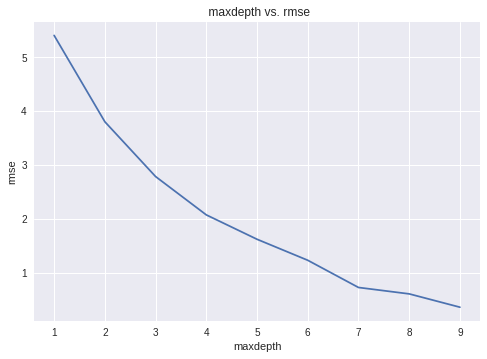

In [35]:
rmse = []
for i in range(1,10):
    gbrt1 = GradientBoostingRegressor(max_depth=i, n_estimators=3, learning_rate=1.0, random_state=42)
    g3 = gbrt1.fit(boston_transformed, lab_train)
    g4 = gbrt1.predict(boston_transformed)
    r = np.sqrt(mean_squared_error(actual, g4))
    rmse.append(r)
plt.plot(range(1,10), rmse)
plt.xlabel("maxdepth")
plt.ylabel("rmse")
plt.title(" maxdepth vs. rmse")

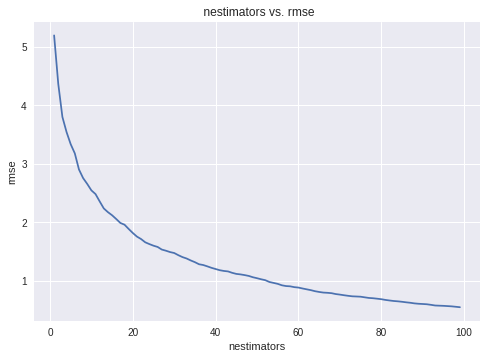

In [36]:
rmse = []
for i in range(1,100):
    gbrt2 = GradientBoostingRegressor(max_depth=2, n_estimators=i, learning_rate=1.0, random_state=42)
    g3 = gbrt2.fit(boston_transformed, lab_train)
    g4 = gbrt2.predict(boston_transformed)
    r = np.sqrt(mean_squared_error(actual, g4))
    rmse.append(r)
plt.plot(range(1,100), rmse)
plt.xlabel("nestimators")
plt.ylabel("rmse")
plt.title(" nestimators vs. rmse")

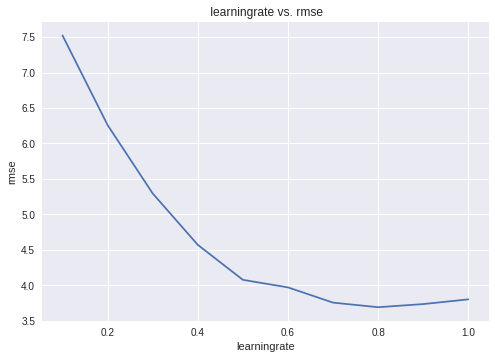

In [37]:
rmse = []
for i in (0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0):
    gbrt3 = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=i, random_state=42)
    g3 = gbrt3.fit(boston_transformed, lab_train)
    g4 = gbrt3.predict(boston_transformed)
    r = np.sqrt(mean_squared_error(actual, g4))
    rmse.append(r)
plt.plot((0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0), rmse)
plt.xlabel("learningrate")
plt.ylabel("rmse")
plt.title(" learningrate vs. rmse")

# Support vector

In [38]:
from sklearn.svm import SVR
svr_reg = SVR()
s1 = svr_reg.fit(boston_transformed, lab_train)
s2 = svr_reg.predict(boston_transformed)
meanerror(actual,s2)
crossval(svr_reg, boston_transformed, lab_train)

(meansquareerror, r2score) =  (5.2043094146325775, 0.67880513957128352)
(cross_val_mean, cross_val_std) =  (5.2151070532081034, 1.8150611137397263)


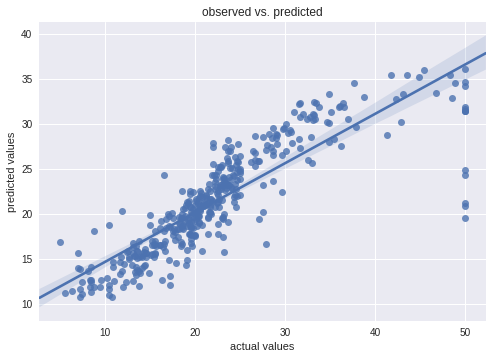

In [39]:
plt.figure()
df = pd.DataFrame({'observed' : actual1, 'predicted' : s2})
x = sns.regplot(actual1, s2, df)
plt.xlabel("actual values")
plt.ylabel("predicted values")
plt.title("observed vs. predicted")
plt.show()

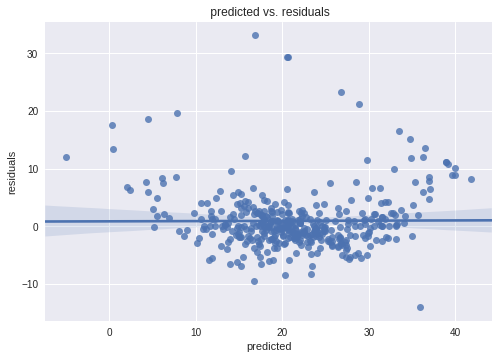

In [42]:
residual = actual - s4
plt.figure()
df = pd.DataFrame({ 'predicted' : s4, 'residuals' : residual})
x = sns.regplot( s4, residual,  df)
plt.xlabel("predicted")
plt.ylabel("residuals")
plt.title(" predicted vs. residuals")
plt.show()

# SVM with linear kernel

In [41]:
svr_reg1 = SVR(kernel='linear')
s3 = svr_reg1.fit(boston_transformed, lab_train)
s4 = svr_reg1.predict(boston_transformed)
meanerror(actual,s4)
crossval(svr_reg1, boston_transformed, lab_train)

(meansquareerror, r2score) =  (5.2303606995993581, 0.67558147205880159)
(cross_val_mean, cross_val_std) =  (5.0999475771115117, 1.5466868207008551)


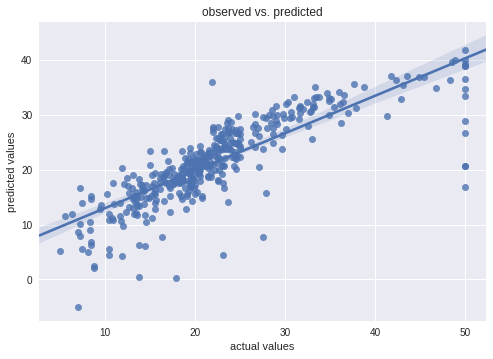

In [43]:
plt.figure()
df = pd.DataFrame({'observed' : actual1, 'predicted' : s4})
x = sns.regplot(actual1, s4, df)
plt.xlabel("actual values")
plt.ylabel("predicted values")
plt.title("observed vs. predicted")
plt.show()

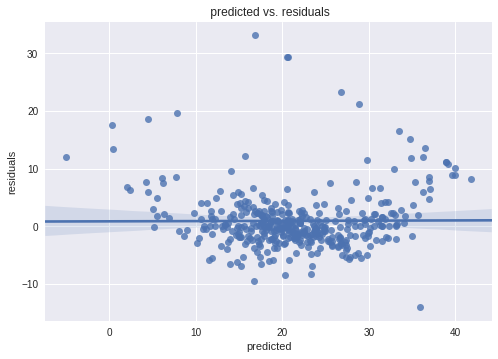

In [44]:
residual = actual - s4
plt.figure()
df = pd.DataFrame({ 'predicted' : s4, 'residuals' : residual})
x = sns.regplot( s4, residual,  df)
plt.xlabel("predicted")
plt.ylabel("residuals")
plt.title(" predicted vs. residuals")
plt.show()

(<matplotlib.text.Text at 0x7f773038d4e0>,
 <matplotlib.text.Text at 0x7f77301b3a58>)

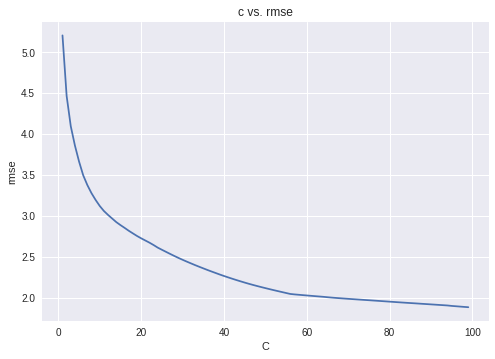

In [45]:
rmse = []
for c in range(1,100):
    svr_reg2 = SVR(C= c)
    s5 = svr_reg2.fit(boston_transformed, lab_train)
    s6 = svr_reg2.predict(boston_transformed)
    r = np.sqrt(mean_squared_error(actual,s6))
    rmse.append(r)
plt.plot(range(1,100), rmse)
plt.xlabel("C"), plt.ylabel("rmse")
plt.title("c vs. rmse")

(<matplotlib.text.Text at 0x7f77301432e8>,
 <matplotlib.text.Text at 0x7f77302056a0>)

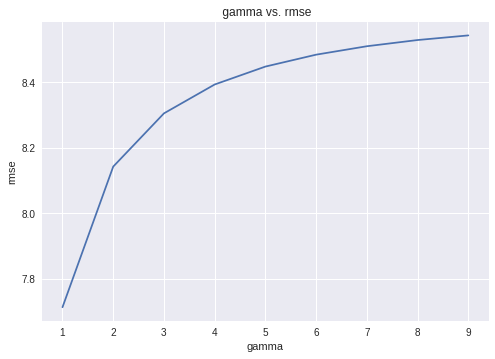

In [46]:
rmse = []
for g in range(1, 10):
    svr_reg2 = SVR(gamma= g)
    s5 = svr_reg2.fit(boston_transformed, lab_train)
    s6 = svr_reg2.predict(boston_transformed)
    r = np.sqrt(mean_squared_error(actual,s6))
    rmse.append(r)
plt.plot(range(1, 10), rmse)
plt.xlabel("gamma"), plt.ylabel("rmse")
plt.title(" gamma vs. rmse")

# PCA

In [135]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 5)
p1 = pca.fit(boston_transformed, lab_train)
p2 = pca.transform(boston_transformed)
pca.components_

array([[ 0.22334672,  0.24865424, -0.24790217,  0.33904205,  0.33152736,
        -0.17645783,  0.29901097, -0.31193025,  0.32419284,  0.34195574,
         0.19957917, -0.19441988,  0.29059745, -0.0026438 ,  0.0026438 ],
       [ 0.46917535,  0.27766438,  0.4079062 , -0.1156549 , -0.16125834,
         0.15980081, -0.33017372,  0.2908318 ,  0.35077374,  0.28821463,
         0.1203305 , -0.19880973, -0.12800669,  0.02621781, -0.02621781],
       [ 0.11561993, -0.02041619,  0.01816016,  0.05866349,  0.25221953,
         0.65678693,  0.19221887, -0.2802563 ,  0.07245574,  0.04388356,
        -0.48789138, -0.05264084, -0.34537894, -0.04846284,  0.04846284],
       [-0.21527376,  0.22940019,  0.28671173, -0.06036865,  0.10075126,
        -0.19440889,  0.01058408,  0.06443522, -0.14418781, -0.10911224,
        -0.48620734, -0.6296074 ,  0.3116537 ,  0.01320096, -0.01320096],
       [-0.24512817, -0.05653003, -0.34500911, -0.07669393, -0.18870115,
         0.33430771, -0.008023  , -0.00666703, 

In [136]:
numeric_cols

['ID',
 'crim',
 'zn',
 'indus',
 'nox',
 'rm',
 'age',
 'dis',
 'rad',
 'tax',
 'ptratio',
 'black',
 'lstat']

In [137]:
c_c = ['chas0', 'chas1']

In [138]:
fea = np.r_[numeric_cols, c_c]
fea

array(['ID', 'crim', 'zn', 'indus', 'nox', 'rm', 'age', 'dis', 'rad',
       'tax', 'ptratio', 'black', 'lstat', 'chas0', 'chas1'], 
      dtype='<U7')

In [139]:
pca.components_[0]

array([ 0.22334672,  0.24865424, -0.24790217,  0.33904205,  0.33152736,
       -0.17645783,  0.29901097, -0.31193025,  0.32419284,  0.34195574,
        0.19957917, -0.19441988,  0.29059745, -0.0026438 ,  0.0026438 ])

In [140]:
z = zip(pca.components_[0], fea)
for i in z:
    print(i)

(0.22334671939963049, 'ID')
(0.24865423543946708, 'crim')
(-0.24790217354613026, 'zn')
(0.33904204935582682, 'indus')
(0.33152736001394972, 'nox')
(-0.17645782788945441, 'rm')
(0.29901096886408407, 'age')
(-0.31193024540064967, 'dis')
(0.32419283858336689, 'rad')
(0.34195574229403825, 'tax')
(0.19957916989650448, 'ptratio')
(-0.19441988392429504, 'black')
(0.29059745414567179, 'lstat')
(-0.0026437982944864319, 'chas0')
(0.0026437982944864328, 'chas1')


In [141]:
s1 = sorted(zip(pca.components_[0], fea), reverse = True)
s1

[(0.34195574229403825, 'tax'),
 (0.33904204935582682, 'indus'),
 (0.33152736001394972, 'nox'),
 (0.32419283858336689, 'rad'),
 (0.29901096886408407, 'age'),
 (0.29059745414567179, 'lstat'),
 (0.24865423543946708, 'crim'),
 (0.22334671939963049, 'ID'),
 (0.19957916989650448, 'ptratio'),
 (0.0026437982944864328, 'chas1'),
 (-0.0026437982944864319, 'chas0'),
 (-0.17645782788945441, 'rm'),
 (-0.19441988392429504, 'black'),
 (-0.24790217354613026, 'zn'),
 (-0.31193024540064967, 'dis')]